In [1]:
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.massfunction import *
from aemulusnu_massfunction.emulator import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [2]:
cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()



from pyccl import lib

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()
print('alist', a_list)


alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459]


We'll model residual 
$$\frac{(N_{\rm true} - N_{\rm emulator,loo})} { N_{\rm true}} \sim \mathcal N\left({\rm Bias}, \frac{{\mathbf C}_{\rm jackknife}}{N_{\rm true}^2} + {\rm diag}(\sigma_{\rm mass-function}^2)\right)$$
Where we model $\sigma_{\rm mass-function}^2$ with a power law
$$\sigma_{\rm mass-function}(\sigma_M) = A + {\rm exp}\left\{b + c  \sigma_M\right\}$$
Where $\{A,b,c\}$ will be our free parametersr

In [3]:
sigMs_for_box = {}
jackknife_for_box = {}
jackknife_rescaled_for_box = {}
R_vecs_for_box = {}
Ms_for_box = {}
weird_boxes = ['Box63_1400', 'Box35_1400', 'Box_n50_38_1400', 'Box5_1400']

for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    cosmo_vals = get_cosmo_vals(cosmo_params[box])
    ccl_cosmo = get_ccl_cosmology(tuple(cosmo_vals))

    ccl_cosmo.compute_sigma()

    NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
    NvM_f = open(NvM_fname, 'rb')
    NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
    NvM_f.close()
    Ms_for_box[box] = {a: NvMs[a]['M'] for a in a_list}
    sigMs = []

    for a in a_list:
        logM = np.log10(NvMs[a]['M'])
        status = 0
        sigM, status = lib.sigM_vec(ccl_cosmo.cosmo, a, logM,
                                        len(logM), status)
        sigMs += [sigM]

    sigMs_dict = {a:sigM for a,sigM in zip(a_list, sigMs)}
    sigMs_for_box[box] = sigMs_dict
    
    R_Vecs = []



    jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
    jackknife_covs_f = open(jackknife_covs_fname, 'rb')
    jackknife = pickle.load(jackknife_covs_f)
    jackknife_covs_f.close()
    jackknife_for_box[box] = {}
    jackknife_rescaled_for_box[box] = {}
    for a in a_list:
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "rb") as f:
            plot_data = pickle.load(f)
        model = plot_data['tinker_eval']
        true  = plot_data['N']
        edges = plot_data['edges']
        edgeslog10 = np.log10(edges)

        jack_cov = jackknife[a][1]
        jackknife_for_box[box][a] = jack_cov 
        jackknife_rescaled_for_box[box][a] = np.array([[jack_cov[i][j]/(NvMs[a]['N'][i] * NvMs[a]['N'][j]) 
                           for j in range(len(jack_cov))] 
                          for i in range(len(jack_cov))])
        
        assert(jack_cov.shape[0] == model.shape[0])
        assert(len(true) == len(model))
        assert(len(true) == len(edges)-1)

        R_Vec = []
        for ledge, redge, model_in_bin, true_in_bin in zip(edgeslog10, edgeslog10[1:], model, true):
            R_Vec += [(model_in_bin-true_in_bin)/true_in_bin]
        R_Vecs += [R_Vec]
    R_vecs_for_box[box]  = dict(zip(a_list, R_Vecs))
#     print(len(R_Vecs))

100%|██████████| 150/150 [09:26<00:00,  3.78s/it]


In [4]:
param_names = ['α', 'β' ]

def sigma_mass_function(α, β, box, a):
    nu  = 1.68647019984/sigMs_for_box[box][a] 
    return  (1-np.exp(α + β * nu))**2
    
    
def get_tot_cov(α, β, box, a):
    sigma_hmf_diag = sigma_mass_function(α, β, box, a) 
    return  jackknife_rescaled_for_box[box][a] + np.diag(np.square(sigma_hmf_diag))


def log_prob(param_values):   
    """    
    Args:
        param_valuesad
        
    Returns:
        float: Resulting log probability
    """
    params = dict(zip(param_names, param_values))
    BIAS = param_values[-1]
    tot_covs = [get_tot_cov(**params, box=box, a=a) for a in a_list for box in R_vecs_for_box]
    R_Vecs = [R_vecs_for_box[box][a] for a in a_list for box in R_vecs_for_box]
    inv_covs =  [np.linalg.inv(tot_cov) for tot_cov in tot_covs]
    scale_covs = [np.log(np.linalg.det(tot_cov)) for tot_cov in tot_covs]
    
    log_probs =  [-0.5 * (len(tot_cov[0])* np.log(2*np.pi) + 
                          np.dot(np.dot((np.array(R_Vec)  - BIAS).T, inv_cov), (np.array(R_Vec) - BIAS)) + 
                          scale_cov) for tot_cov, inv_cov, scale_cov, R_Vec in zip(tot_covs, 
                                                                                   inv_covs, 
                                                                                   scale_covs, 
                                                                                   R_Vecs)]
    
    if not np.isfinite(sum(log_probs)):
        return -np.inf
    return sum(log_probs)


In [5]:
guess = np.random.uniform(size=(3))
# print(log_prob(guess))

# guess=[0,0,0] 
# print('%.1e'%log_prob(guess))


In [6]:
nll = lambda *args: -log_prob(*args)
from scipy import optimize as optimize


result = optimize.minimize(nll, guess,  method='Nelder-Mead', options={
    'maxiter': len(guess)*10000
})

In [7]:
print(guess)
print(result)

[0.29841364 0.73343195 0.51109801]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -90765.04086746325
             x: [ 7.955e-02  9.965e-04 -3.172e-03]
           nit: 159
          nfev: 279
 final_simplex: (array([[ 7.955e-02,  9.965e-04, -3.172e-03],
                       [ 7.956e-02,  9.878e-04, -3.171e-03],
                       [ 7.955e-02,  9.934e-04, -3.172e-03],
                       [ 7.954e-02,  1.004e-03, -3.171e-03]]), array([-9.077e+04, -9.077e+04, -9.077e+04, -9.077e+04]))


In [8]:
best = result['x']
best_params = dict(zip(param_names, best))
print(best_params)
bias = best[-1]
print('bias:', bias)

{'α': 0.07955078958986264, 'β': 0.0009964648035650572}
bias: -0.003171807031781419


In [9]:
print('%.1e'%log_prob(best))


9.1e+04


In [10]:
import matplotlib as mpl

In [11]:
plt.show()

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 23


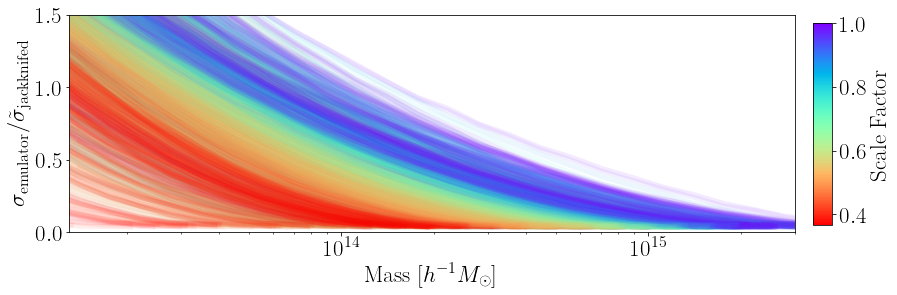

In [12]:
plt.figure(figsize=(13, 4))
mn = 1e12
mx = 5e15


import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))
norm = mcolors.Normalize(vmin=min(a_list), vmax=max(a_list))
colormap = cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['rainbow_r'])

for box in jackknife_rescaled_for_box:
    for i, (a, z) in enumerate(zip(a_list, z_list)):
        plt.plot(Ms_for_box[box][a], sigma_mass_function(**best_params, box=box, a=a)/np.sqrt(np.diagonal(jackknife_rescaled_for_box[box][a])),
                color=colormap.to_rgba(a), lw=5, alpha=0.08)

plt.xscale('log', base=10)
# plt.yscale('log', base=10)
# plt.legend(frameon=False)
plt.xlim(1.3e13, 3e15)
plt.ylim(0, 1.5)
plt.xlabel(r'Mass $[h^{-1} M_\odot]$')
plt.ylabel(r'$\sigma_{\rm emulator} / \tilde\sigma_{\rm jackknifed}$')
# Add a colorbar
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=cm.rainbow_r, norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar

plt.savefig('ratio_sigemulator_sigjackknife.pdf', bbox_inches='tight')
plt.savefig('ratio_sigemulator_sigjackknife.png', bbox_inches='tight')

In [13]:
print(1)

1


In [14]:
# x = np.random.randn(10000, 3)



import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))
norm = mcolors.Normalize(vmin=min(a_list), vmax=max(a_list))
colormap = cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['rainbow_r'])


tot_covs = [get_tot_cov(**best_params, box=box, a=a) for a in a_list for box in R_vecs_for_box]
# tot_covs = [jackknife_rescaled_for_box[box][a] for a in a_list for box in R_vecs_for_box]

R_Vecs = [R_vecs_for_box[box][a] for a in a_list for box in R_vecs_for_box]


chi2s =  [np.dot(np.dot((np.array(R_vec) - bias).T, np.linalg.inv(tot_cov)), (R_vec - bias)) for R_vec, tot_cov in zip(R_Vecs, tot_covs)]
# Flatten the nested list
R_Vecs_flattened = np.concatenate([np.array(sublist).flatten() for sublist in R_Vecs])

# Get the total number of elements using np.ones_like
total_elements = np.sum(np.ones_like(R_Vecs_flattened))

dof = total_elements - 3


print(sum(chi2s)/dof)



1.131457461592959


2044 686


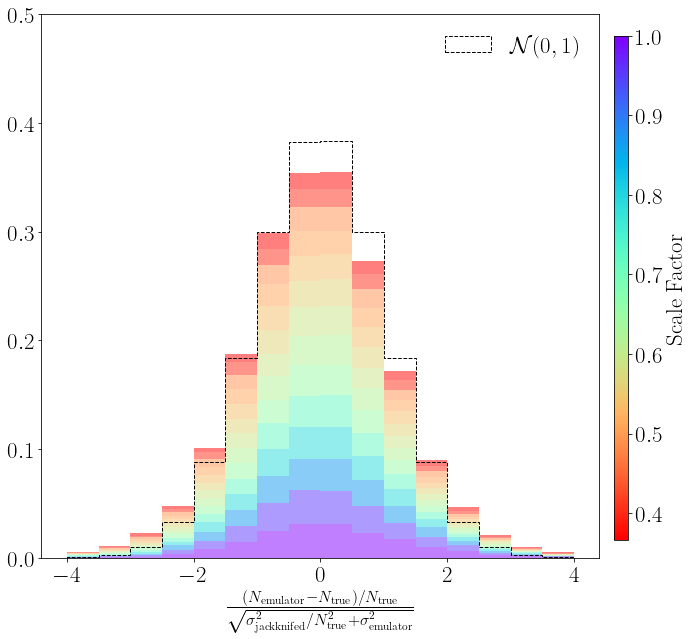

In [15]:
plt.figure(figsize=(10,10))

x = [(R_Vec - bias) / np.sqrt(np.diagonal(tot_cov)) for R_Vec, tot_cov in zip(R_Vecs, tot_covs)]
print(len(x), len(a_list)*(50-1))

import matplotlib as mpl
import matplotlib.colors as mcolors

rainbow_list = []
for i, a in enumerate(a_list):
    for box in R_vecs_for_box:
        rainbow_list += [colormap.to_rgba(a)]

# Define your custom bins
bin_edges = np.arange(-4, 4.1, 0.5)  

# Plot original histogram using custom bin edges
n1, bins1, patches1 = plt.hist(x, bins=bin_edges, density=True, histtype='bar', 
                               stacked=True, alpha=1, color=rainbow_list) 

# Generate random samples from a normal distribution with mean=0 and variance=1
normal_data = np.random.normal(0, 1, 10000000)

# Plot histogram of normal distribution using the same custom bin edges
n2, bins2, patches2 = plt.hist(normal_data, bins=bin_edges, density=True, histtype='step', linestyle='dashed', edgecolor='black', facecolor='none', label=r'$\mathcal N(0,1)$')
# Add labels and title
plt.xlabel(r'$\frac{(N_{\rm emulator} - N_{\rm true})/N_{\rm true}}{\sqrt{\sigma_{\rm jackknifed}^2 / {N_{\rm true}^2} + \sigma_{\rm emulator}^2}}$')
# plt.ylabel('Density')
plt.yticks([])
# plt.title('Histogram')

# Compute the chi2 metric between the two histograms
# chi2_metric = np.sum(((n1 - n2) ** 2) / (n1 + n2))

# plt.title(r'$\chi^2$: %.2f'%(chi2_metric))

plt.legend(frameon=False)
plt.ylim([0, 0.42])
cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] of colorbar axes
cbar = ColorbarBase(cbar_ax, cmap=mpl.colormaps['rainbow_r'], norm=norm, orientation='vertical')
cbar.set_label('Scale Factor')  # Set the label for the colorbar
plt.savefig('hist_chi2.pdf', bbox_inches='tight')
plt.savefig('hist_chi2.png', bbox_inches='tight')

In [16]:
# x = np.random.randn(10000, 3)



import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm

z_list = list(map(scaleToRedshift, a_list))
norm = mcolors.Normalize(vmin=min(a_list), vmax=max(a_list))
colormap = cm.ScalarMappable(norm=norm, cmap=mpl.colormaps['rainbow_r'])


# tot_covs = [get_tot_cov(**best_params, box=box, a=a) for a in a_list for box in R_vecs_for_box]
tot_covs = [jackknife_rescaled_for_box[box][a] for a in a_list for box in R_vecs_for_box]

R_Vecs = [R_vecs_for_box[box][a] for a in a_list for box in R_vecs_for_box]


chi2s =  [np.dot(np.dot(np.array(R_vec).T, np.linalg.inv(tot_cov)), R_vec) for R_vec, tot_cov in zip(R_Vecs, tot_covs)]
# Flatten the nested list
R_Vecs_flattened = np.concatenate([np.array(sublist).flatten() for sublist in R_Vecs])

# Get the total number of elements using np.ones_like
total_elements = np.sum(np.ones_like(R_Vecs_flattened))

dof = total_elements - 3


print(sum(chi2s)/dof)



2.2576702145407905
